In [ ]:
!pip install datasets==3.6.0
!pip install transformers==4.51.3

In [ ]:
from datasets import load_dataset
import torch
from torch.utils.data import IterableDataset, DataLoader
from datasets import load_dataset
from transformers import AutoProcessor
import torch
from torch.utils.data import Dataset

In [ ]:
class DocLayNetDataset(IterableDataset):

    def __init__(self, split="train", streaming=True, max_examples=None):
        self.dataset = load_dataset(
            "ds4sd/DocLayNet-v1.2",
            split=split,
            streaming=streaming,
            trust_remote_code=True
        )
        self.max_examples = max_examples
        self.categories = {
            1: "caption", 2: "footnote", 3: "formula", 4: "listitem",
            5: "footpage", 6: "header", 7: "picture",
            8: "subheader", 9: "table", 10: "text", 11: "title"
        }

    def normalize_bbox(self, bbox, img_width, img_height):
        """Convert bbox to Florence format: [x, y, w, h] -> """
        x, y, w, h = bbox
        x1 = int(round((x / img_width) * 999))
        y1 = int(round((y / img_height) * 999))
        x2 = int(round(((x + w) / img_width) * 999))
        y2 = int(round(((y + h) / img_height) * 999))

        # Clip to valid range
        x1, y1 = max(0, min(999, x1)), max(0, min(999, y1))
        x2, y2 = max(0, min(999, x2)), max(0, min(999, y2))

        return x1, y1, x2, y2

    def convert_to_florence(self, example):
        """Convert example to (prompt, image) format where prompt = prefix + suffix."""
        prefix = ""
        suffix_parts = []

        # Get image dimensions from PIL image
        image = example['image']

        img_width, img_height = image.size

        # Iterate through bboxes and category_ids
        bboxes = example.get('bboxes', [])
        category_ids = example.get('category_id', [])

        for bbox, cat_id in zip(bboxes, category_ids):

            x1, y1, x2, y2 = self.normalize_bbox(bbox, img_width, img_height)
            cat_id = self.categories[cat_id]
            suffix_parts.append(f"{cat_id}<loc_{x1}><loc_{y1}><loc_{x2}><loc_{y2}>")

        suffix = "".join(suffix_parts)
        prompt = suffix
        return prompt, image

    def __iter__(self):
        """Required for IterableDataset - yields individual samples."""
        count = 0
        for example in self.dataset:
            if self.max_examples is not None and count >= self.max_examples:
                break
            try:
                prompt, image = self.convert_to_florence(example)
                yield {"prompt": prompt, "image": image}
                count += 1
            except Exception as e:
                print(f"Skipping example due to error: {e}")
                continue

    def __len__(self):
        if self.max_examples is not None:
            return self.max_examples
        return self.dataset.info.splits['train'].num_examples




In [ ]:
train_dataset = DocLayNetDataset(split="train", streaming=True)

# Validation dataset - only 200 examples
val_dataset = DocLayNetDataset(split="validation", streaming=True, max_examples=200)

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

In [ ]:
def collate_fn(batch, processor, device='cuda'):
    """
    Collate function for Florence-2 training.
    Processes both prompts and images through the Florence-2 processor.
    """
    # Extract prompts and images from batch
    prompts = [item["prompt"] for item in batch]
    images = [item["image"] for item in batch]

    # Process inputs with Florence processor
    inputs = processor(
        text=['<OD>' for _ in range(len(prompts))],
        images=images,
        return_tensors="pt",
        padding=True,
        max_length=4096,
        truncation=True
    ).to(device)

    # Also process the target labels (same as prompts for autoregressive training)
    labels = processor.tokenizer(
        text=prompts,
        return_tensors="pt",
        padding=True,
        max_length=4096,
        truncation=True
    ).input_ids.to(device)

    inputs["labels"] = labels


    return inputs





# Usage with DataLoader:
from functools import partial

# Load processor
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base",trust_remote_code=True)

# Create partial function with processor and device
collate_fn_partial = partial(collate_fn, processor=processor, device='cuda')

# Create DataLoader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    num_workers=0,
    collate_fn=collate_fn_partial
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=1,
    num_workers=0,
    collate_fn=collate_fn_partial
)




In [ ]:
from transformers import AutoModelForCausalLM, AutoProcessor
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Florence-2-base",
    trust_remote_code=True
).to(device)

for param in model.vision_tower.parameters():
  param.is_trainable = False


In [ ]:
from tqdm import tqdm
from transformers import  get_scheduler
from torch.optim import AdamW

epochs = 2
optimizer = AdamW(model.parameters(), lr=1e-6)
num_training_steps = epochs * len(train_dataloader)

lr_scheduler = get_scheduler(name="linear", optimizer=optimizer,
                              num_warmup_steps=0, num_training_steps=num_training_steps,)

In [2]:
for epoch in range(epochs):
  train_loss = 0
  model.train()
  step = 0

  for inputs in train_dataloader:
    input_ids = inputs["input_ids"]
    pixel_values = inputs["pixel_values"]
    labels  = inputs["labels"]
    outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    train_loss += loss.item()

    step += 1

    # Save every 50 steps
    if step % 100 == 0:
      model.save_pretrained(f"./checkpointsv2/model_v1/epoch_{epoch}_step_{step}")
      print(f"Saved checkpoint at epoch {epoch}, step {step}")
    if step%10==0:
      print(train_loss/step)

  model.eval()
  val_loss = 0
  for inputs in val_dataloader:
    input_ids = inputs["input_ids"]
    pixel_values = inputs["pixel_values"]
    labels  = inputs["labels"]
    with torch.no_grad():
      outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
    loss = outputs.loss
    val_loss += loss.item()

  print(val_loss/len(val_dataloader),"val_loss",train_loss/len(train_dataloader),"train_loss")

  # Save at end of each epoch
  model.save_pretrained(f"./checkpoints/epoch_{epoch}_final")
  print(f"Saved final checkpoint for epoch {epoch}")

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    "/content/checkpoints/model_v1/epoch_0_step_1600",
    trust_remote_code=True
).to(device)

In [ ]:
import supervision as sv
from PIL import Image
import numpy as np

# Load image
image_path = '/content/Screenshot From 2025-10-16 16-09-55.png'
image = Image.open(image_path).convert('RGB')

# ----- MODEL INFERENCE -----
task = "<OD>"
text = "<OD>"

inputs = processor(
    text=text,
    images=image,
    return_tensors="pt"
).to('cuda')

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=4096,
    num_beams=3
)

generated_text = processor.batch_decode(
    generated_ids, skip_special_tokens=False
)[0]
# Postprocess to get detections
response = processor.post_process_generation(
    generated_text,
    task=task,
    image_size=image.size
)
print("Generated text:", generated_text)




Generated text: </s><s>subheader<loc_243><loc_88><loc_285><loc_98>subheader<loc_733><loc_88><loc_842><loc_99>subheader<loc_514><loc_489><loc_653><loc_501>text<loc_118><loc_497><loc_486><loc_523>text<loc_118><loc_556><loc_487><loc_729>text<loc_118><loc_747><loc_487><loc_872>text<loc_118><loc_876><loc_487><loc_920>text<loc_514><loc_765><loc_881><loc_904>text<loc_514><loc_579><loc_882><loc_654>text<loc_514><loc_672><loc_882><loc_747>text<loc_514><loc_518><loc_882><loc_562></s>


✅ Annotated image saved to /content/annotated_output.png


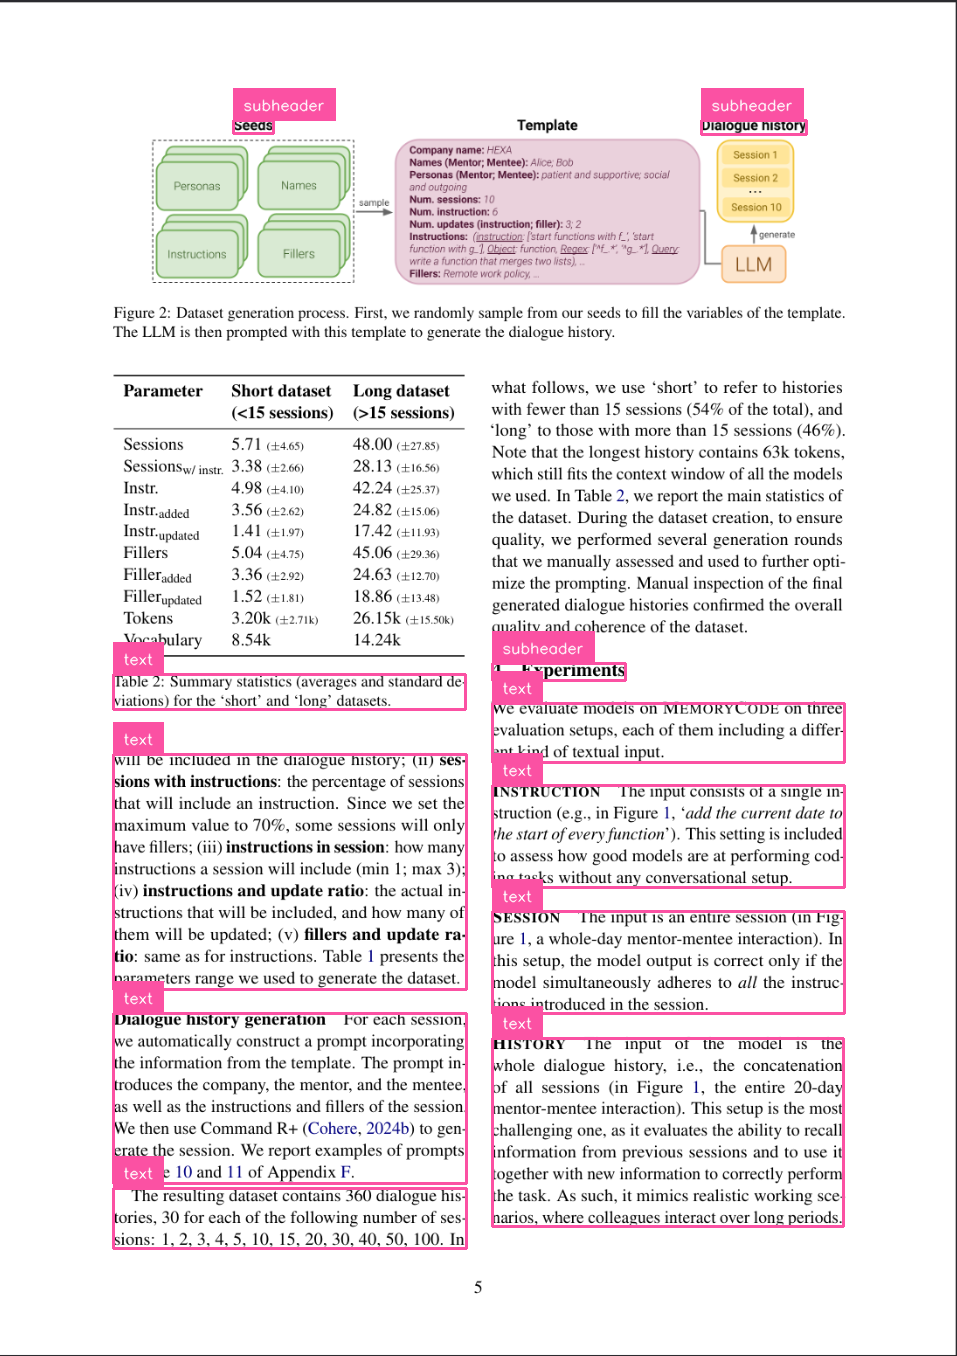

In [ ]:
# robust_supervision_draw.py
import supervision as sv
from PIL import Image
import numpy as np
import cv2

# --- load image (same as you had) ---
pil_img = Image.open(image_path).convert('RGB')
img = np.array(pil_img)  # numpy image for supervision / cv2 (RGB order)

# --- response from your processor (example shown by you) ---
# response = {'<OD>': {'bboxes': [[x1,y1,x2,y2], ...], 'labels': ['table', ...]}}
od = response.get('<OD>', {})
bboxes = od.get('bboxes', [])
labels = od.get('labels', [])

if not bboxes:
    print("⚠️ No bboxes found in response.")
else:
    # Convert to numpy xyxy array
    xyxy = np.array(bboxes, dtype=np.float32)

    # Ensure sv.Detections has a class_id array (some annotators use it)
    # We'll set class_id to zeros if missing; LabelAnnotator accepts a labels list separately.
    try:
        detections = sv.Detections(xyxy=xyxy, class_id=np.zeros(len(xyxy), dtype=int))
    except TypeError:
        # older versions might expect different params - try minimal
        detections = sv.Detections(xyxy=xyxy)

    # --- choose bounding-box annotator depending on installed version ---
    # Newer supervision may provide BoundingBoxAnnotator; older used BoxAnnotator
    BoundingAnnotator = None
    for cand in ("BoundingBoxAnnotator", "BoxAnnotator", "RoundBoxAnnotator", "OrientedBoxAnnotator"):
        if hasattr(sv, cand):
            BoundingAnnotator = getattr(sv, cand)
            break

    if BoundingAnnotator is None:
        # fallback: try sv.BoxAnnotator (older name) or just draw with opencv
        try:
            box_annotator = sv.BoxAnnotator(thickness=2)
            use_box_annotator = True
        except Exception:
            box_annotator = None
            use_box_annotator = False
    else:
        # instantiate bounding-box-style annotator with conservative args
        try:
            box_annotator = BoundingAnnotator()
            use_box_annotator = True
        except Exception:
            # fallback to BoxAnnotator if present
            try:
                box_annotator = sv.BoxAnnotator()
                use_box_annotator = True
            except Exception:
                box_annotator = None
                use_box_annotator = False

    annotated = img.copy()

    # If a supervision box annotator is available, use it to draw boxes (no labels)
    if use_box_annotator and box_annotator is not None:
        # BoxAnnotator.annotate(scene, detections, custom_color_lookup=None)
        try:
            annotated = box_annotator.annotate(scene=annotated, detections=detections)
        except TypeError:
            # Some older versions expect positional args
            annotated = box_annotator.annotate(annotated, detections)

    else:
        # fallback: draw boxes with OpenCV
        for (x1, y1, x2, y2) in xyxy:
            cv2.rectangle(annotated, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

    # --- draw labels using LabelAnnotator if available ---
    if hasattr(sv, "LabelAnnotator"):
        label_annotator = sv.LabelAnnotator()
        # LabelAnnotator.annotate(scene, detections, labels=None, custom_color_lookup=None)
        try:
            annotated = label_annotator.annotate(scene=annotated, detections=detections, labels=labels)
        except TypeError:
            # some builds accept labels as positional arg
            annotated = label_annotator.annotate(annotated, detections, labels)
    else:
        # fallback: draw labels with OpenCV (simple)
        for (x1, y1, x2, y2), label in zip(xyxy.tolist(), labels):
            text = str(label)
            org = (int(x1) + 5, max(15, int(y1) - 5))
            # put a filled rectangle behind text for readability
            (w, h), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
            cv2.rectangle(annotated, (org[0]-2, org[1]-h-2), (org[0]+w+2, org[1]+2), (0,255,0), -1)
            cv2.putText(annotated, text, org, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 1, cv2.LINE_AA)

    # --- save and show ---
    out_path = "/content/annotated_output.png"
    # annotated is RGB; convert to BGR for cv2.imwrite OR use PIL to save
    annotated_pil = Image.fromarray(annotated)
    annotated_pil.save(out_path)
    print("✅ Annotated image saved to", out_path)

    # If running in notebook, display inline (optional)
    try:
        display(annotated_pil)
    except Exception:
        pass
